## **DAT 402 Project 1**   
## **Spotify Song Popularity Prediction**

**Team Members:**
- Pete VanBenthuysen
- Emily Szolnoki

**Project Goal:**
Predict whether a song will be popular (popularity $ \geq 59 $) based on its musical features, such as danceability, energy, and tempo. This project helps us identify which characteristics are most influential in determining whether a song becomes popular. We are most interested in analyzing and building a model to predict song popularity based on those musical attributes and more, allowing for potential insights in playlist curation and music production.

**Dataset:**
We are using a dataset from Kaggle called 'Ultimate Spotify Tracks DB'. The raw dataset includes 18 columns and 232,725 rows with a mix of categorical and numerical features. There are also no missing values.

[Kaggle dataset page](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db).

**Columns:**
- **genre**: Genre of the song.
- **artist_name**: Name of the artist.
- **track_name**: Name of the track.
- **track_id**: Unique ID for each track.
- **popularity**: Popularity score of the song (ranging from 0 to 100).
- **acousticness**: A measure of how acoustic the song is (ranging from 0 to 1).
- **danceability**: How suitable the song is for dancing (ranging from 0 to 1).
- **duration_ms**: Duration of the trach in milliseconds.
- **energy**: A measure of energy, typically related to the intensity and activity of the track (ranging from 0 to 1).
- **instrumentalness**: A measure of whether the track is instrumental (ranging from 0 to 1).
- **key**: The musical key of the track.
- **liveness**: Measure of the presence of a live audience (ranging from 0 to 1).
- **loudness**: The overall loudness of the track in decibels.
- **mode**: The modality of the track.
- **speechiness**: Speechiness measure of the track (ranging from 0 to 1).
- **tempo**: The tempo (beats per minute) of the track.
- **time_signature**: The time signature of the track.
- **valence**: A measure of musical positiveness (ranging from 0 to 1).

For more information on what these data points mean, checkout the description [Here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)

### **Imports**

In [27]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,

    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split as tts

# Preprocessing
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler

### **Data Loading, Cleaning, and Preprocessing**

After importing all necessary libraries, we begin exploring the dataset by loading it and reviewing the first few rows to understand its structure. We also check for any missing values to assess data quality. These initial steps help ensure the data is clean and prepared for analysis and modeling.

In [28]:
### 1) Loading, cleaning, and preprocessing the dataset ###

# Load dataset
df = pd.read_csv("data/SpotifyFeatures.csv", parse_dates=False) # Set parse_dates=False to avoid parsing dates
print("First 5 Rows of the Dataset:")
print(df.head())

print("Count of Missing Values in Each Column:")
print(df.isnull().sum()) # Check for missing values

First 5 Rows of the Dataset:
   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373 

Next, we check for duplicates in the dataset. Some songs appear multiple times under the same track ID but are associated with different genres. To create a more balanced and consistent dataset, we remove all songs with duplicate track IDs, keeping only the first occurrence. In total, we identified 35,124 tracks with duplicate track IDs and 20,827 tracks listed under multiple genres. This resulted in the removal of 55,951 entries to ensure that each song appears only once and is associated with a single genre.

In [29]:
# Check for duplicate track_ids with different genres
dupes = df[df.duplicated(subset=['track_id'], keep=False)]
num_dupes = dupes['track_id'].nunique()
total_dupe_rows = dupes.shape[0]

print(f"\nFound {num_dupes} duplicated track_ids with conflicting genres.")
print(f"This affects a total of {total_dupe_rows} rows.\n")
print("Sample of duplicate conflicts:")
print(dupes[['track_id', 'track_name', 'genre']].sort_values(by='track_id').head(10))

before_dedup = df.shape[0]
# Remove duplicates based on track_id, keeping the first occurrence
df = df.drop_duplicates(subset='track_id', keep='first')
after_dedup = df.shape[0]

print(f"\nRemoved {before_dedup - after_dedup} duplicate rows based on track_id.\n")


Found 35124 duplicated track_ids with conflicting genres.
This affects a total of 91075 rows.

Sample of duplicate conflicts:
                      track_id           track_name             genre
14492   000xQL6tZNLJzIrtIgxqSl       Still Got Time             Dance
110840  000xQL6tZNLJzIrtIgxqSl       Still Got Time               Pop
96926   001gDjxhKGDSx4sMMAgS9R              Kingdom  Children’s Music
153533  001gDjxhKGDSx4sMMAgS9R              Kingdom              Rock
65253   001ifh9Zkyc5DhK7AGQRtK               Gemini              Folk
145387  001ifh9Zkyc5DhK7AGQRtK               Gemini             Indie
201614  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away        Soundtrack
182413  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away             Movie
121130  002QT7AS6h1LAF5dla8D92  Still Smell Like It               Rap
90714   002QT7AS6h1LAF5dla8D92  Still Smell Like It           Hip-Hop

Removed 55951 duplicate rows based on track_id.



The first column we addressed was the time_signature column, which represents the number of beats in a measure. We began by removing invalid entries, such as '0/4', to clean the data and improve the accuracy of the distribution. We then converted the values to display only the numerator, as the fractional format is unnecessary and can be difficult for a model to interpret.

In [30]:
# Check output of time_signature
print("Proportion of Each Value in 'time_signature':")
print(df['time_signature'].value_counts(normalize=True))

# Remove rows with invalid time signature and convert to integer
df = df[df['time_signature'] != '0/4']
df['time_signature'] = df['time_signature'].str.extract('(\d+)').astype(int)

Proportion of Each Value in 'time_signature':
time_signature
4/4    0.843942
3/4    0.117698
5/4    0.025060
1/4    0.013266
0/4    0.000034
Name: proportion, dtype: float64


To make the duration_ms feature more interpretable, we created a new column called duration_sec, which represents the duration in seconds and replaces the original millisecond format.

In [31]:
# Convert duration from milliseconds to seconds for easier interpretation
df['duration_sec'] = df['duration_ms'] / 1000

The genre column contained several inconsistencies. For example, there were two separate categories for "Children's Music," which we merged into one. We then removed both "Comedy" and "Children's Music" from the dataset, as they were outside the scope of our analysis. Additionally, we combined the "Rap" and "Hip-Hop" genres into a single category to create a more balanced distribution across genres. All other genres were kept separate, as they did not share enough similarities to justify merging.

We also dropped the "track_name," "track_id," and "artist_name" columns, as they did not provide meaningful predictive value for our model.

In [32]:
# Fix the genre name
df['genre'] = df['genre'].replace("Children’s Music", "Children's Music") 

# Drop genres that are not relevant for our analysis
df = df[~df['genre'].isin(['Comedy', "Children's Music"])]

# Combine "Hip-Hop" and "Rap" into "Hip-Hop_Rap"
df['genre'] = df['genre'].replace({'Hip-Hop': 'Hip-Hop_Rap', 'Rap': 'Hip-Hop_Rap'})

# Check the updated genre distribution
print("\nCount of Each Genre in the Dataset:")
print(df['genre'].value_counts())

# Drop columns we don't want the model to use
df = df.drop(columns=['track_name', 'track_id', 'artist_name', 'duration_ms'])


Count of Each Genre in the Dataset:
genre
Electronic     9149
Alternative    9095
Anime          8935
Hip-Hop_Rap    8869
Classical      8711
Reggae         8687
Reggaeton      8549
Blues          8496
Soundtrack     8480
Opera          8277
Folk           8048
Jazz           8039
Ska            8017
Dance          7981
World          7972
Movie          7802
Country        7383
R&B            5353
Soul           4430
Indie          3318
Pop            2417
Rock           2227
A Capella       119
Name: count, dtype: int64


Next, we defined our binary target variable. We began by identifying the threshold for popularity, which we set as the top 10% of all songs based on their popularity score. This threshold corresponded to a score of 59. We then created a new binary column called "is_popular," where a value of 1 indicates that the song has a popularity score greater than or equal to 59, and a value of 0 indicates a score below 59.

In [33]:
# Statistically define threshold for popularity based on top 10%
threshold = df['popularity'].quantile(0.90) # Top 10%
df['is_popular'] = (df['popularity'] >= threshold).astype(int)
print(f"\nUsing popularity threshold: {threshold:.2f}") #59.0
print("Class Distribution for 'is_popular' (Proportions):")
print(df['is_popular'].value_counts(normalize=True)) # Check class distribution

df = df.drop(columns=['popularity'])
df = df.drop_duplicates()


Using popularity threshold: 59.00
Class Distribution for 'is_popular' (Proportions):
is_popular
0    0.896766
1    0.103234
Name: proportion, dtype: float64


To finalize the loading and cleaning of the dataset, we performed final quality checks to ensure it was ready for exploratory data analysis. We confirmed that there were no missing values, all column names and data types were appropriate, there were no duplicate entries, and the overall shape of the dataset was accurate. After cleaning, the dataset contained 15 columns and 159,981 songs.

In [34]:
# Final quality checks
print("\n Quality checks:")
print("Missing values:\n")
print(df.isnull().sum())       # Check for missing values

print("\nData types:\n")
print(df.dtypes)               # Confirm correct data types

print("\nColumns in dataset:")
print(list(df.columns))        # Final column names

# Final duplicate check
num_duplicates = df.duplicated(keep=False).sum()
print(f"\nExact duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Sample duplicates:\n", df[df.duplicated(keep=False)].head(10))
else:
    print("No exact duplicate rows found.")

# Dataset shape after cleaning
print(f"\nCleaned dataset shape: {df.shape}")

# List of columns after cleaning
print(f"\nColumns after cleaning: {df.columns.tolist()}")


 Quality checks:
Missing values:

genre               0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
duration_sec        0
is_popular          0
dtype: int64

Data types:

genre                object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
time_signature        int32
valence             float64
duration_sec        float64
is_popular            int32
dtype: object

Columns in dataset:
['genre', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 

### **Exploratory Data Analysis (EDA)**

To better understand the dataset and prepare for modeling, we conducted extensive exploratory data analysis.

We began our EDA by reviewing the summary statistics, which provided insight into the scale and distribution of each feature. Additionally, we examined the distribution of the time_signature column to understand the frequency of different time signatures across the songs.

In [35]:
### 1.5) EDA Checks ###

print(f"\nSummary statistics:\n{df.describe()}")  # Summary statistics
print(f"\nTime signature distribution:\n{df['time_signature'].value_counts(normalize=True)}")  # Categorical breakdown


Summary statistics:
        acousticness   danceability         energy  instrumentalness  \
count  159981.000000  159981.000000  159981.000000     159981.000000   
mean        0.376090       0.534982       0.554121          0.184452   
std         0.362517       0.193880       0.278229          0.330984   
min         0.000000       0.056900       0.000020          0.000000   
25%         0.037400       0.401000       0.338000          0.000000   
50%         0.236000       0.552000       0.592000          0.000154   
75%         0.740000       0.683000       0.787000          0.150000   
max         0.996000       0.987000       0.999000          0.999000   

            liveness       loudness    speechiness          tempo  \
count  159981.000000  159981.000000  159981.000000  159981.000000   
mean        0.196569     -10.020473       0.084368     118.181187   
std         0.171005       6.530106       0.093885      31.189596   
min         0.009670     -52.457000       0.022200    

First, we examined the distribution of songs across genres in the dataset. The bar chart showed that the genres are generally well-distributed, and no further adjustments were necessary.

We observed that the Electronic and Alternative genres each contain approximately 18,000 songs out of the 159,981 in the cleaned dataset. In contrast, A Capella has the fewest entries among all genres.

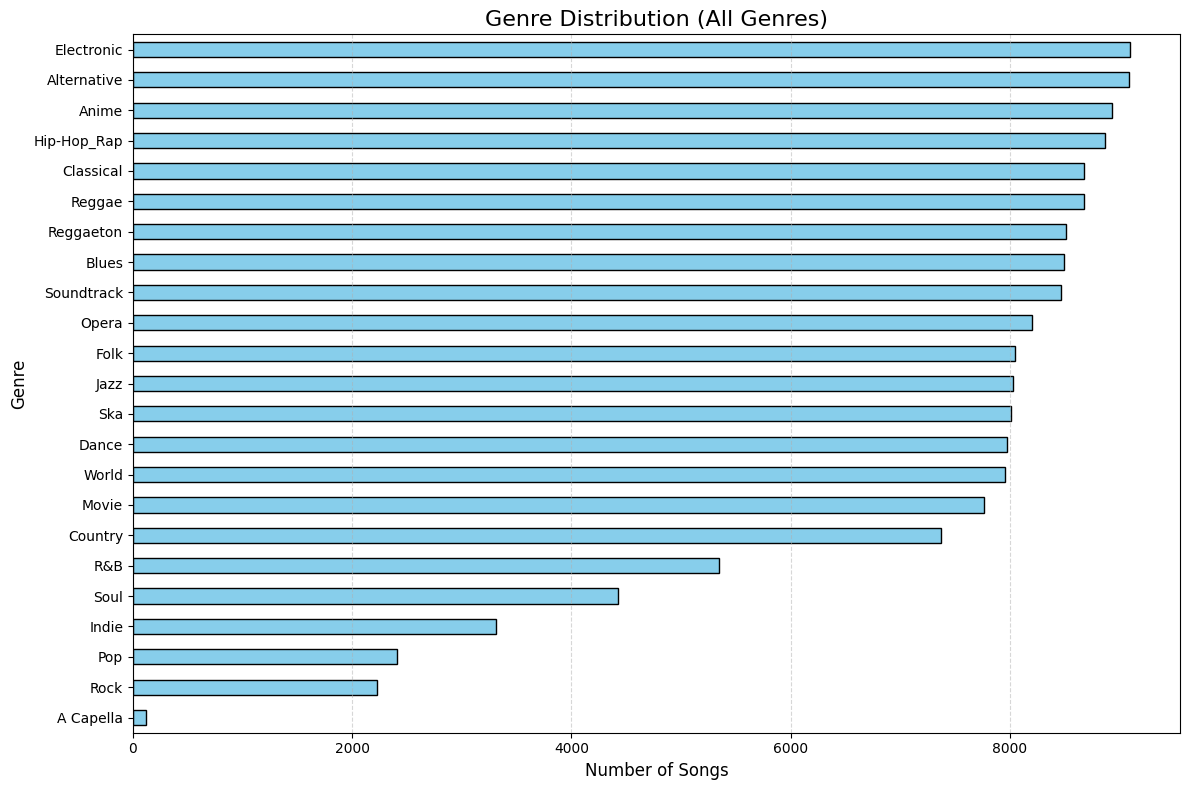

In [36]:
### 2) EDA ###

# Genre overview via bar chart
genre_counts = df['genre'].value_counts() # Count songs per genre
 
# Plot
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Genre Distribution (All Genres)', fontsize=16)
plt.xlabel('Number of Songs', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Flip the y-axis to show most common genres on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

Our first concern was the presence of potential outliers in the duration_sec column. Since the dataset is sourced from Spotify’s API and is updated regularly, it includes not only music but also audiobooks and podcasts. These non-music entries can significantly distort the distribution and negatively impact model performance. To investigate this, we began by plotting a histogram of the duration_sec column, which confirmed our concerns.

To address the issue, we applied the Interquartile Range (IQR) method to filter out outliers. We calculated the IQR using the 25th percentile (Q1) and the 75th percentile (Q3), and removed any songs with durations falling outside the range of Q1 - 1.5IQR to Q3 + 1.5IQR. These were considered extreme values unlikely to represent typical song durations.

This filtering step allowed us to narrow the dataset to focus on more representative entries. After removing 9,888 outliers, a new histogram of the duration_sec column showed a much cleaner and more normalized distribution.

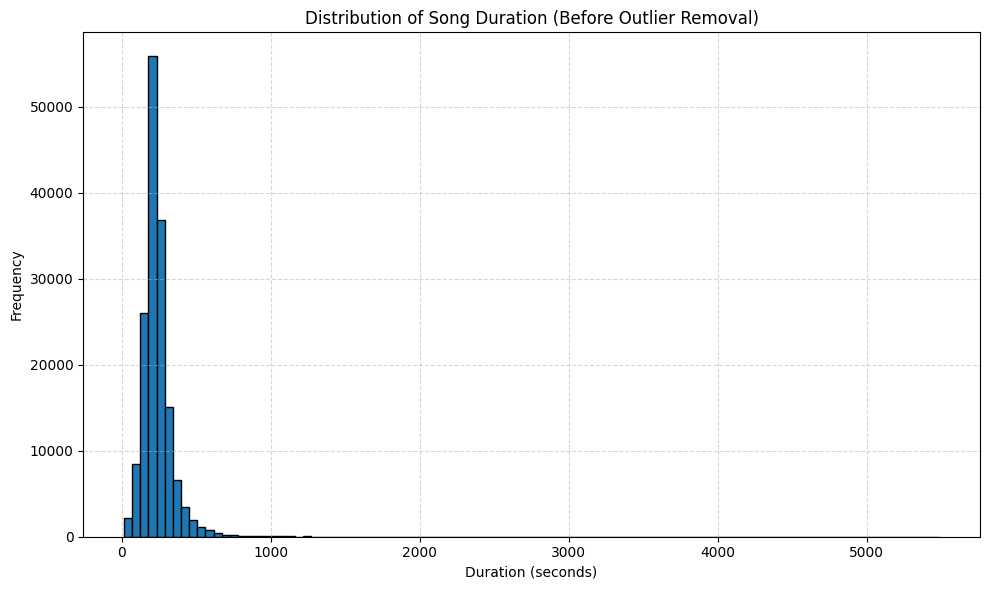


Duration IQR Analysis
Outliers detected: 9888
Songs removed from dataset: 9888
IQR Range: 54 to 400 seconds
Original duration range: 53.867 to 399.827 seconds
Remaining dataset size: 150,093 songs


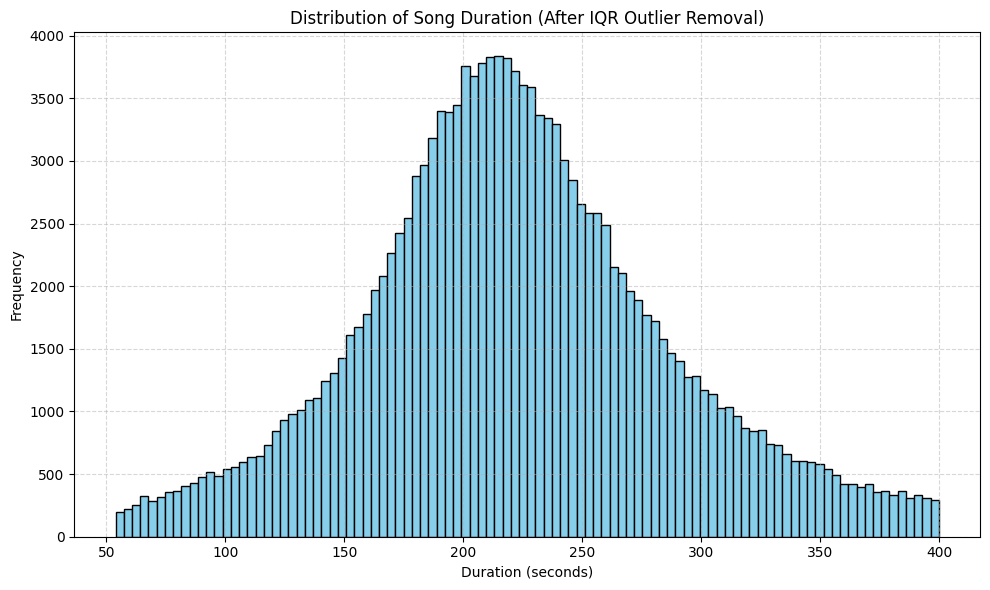

In [37]:
### IQR Analysis for Duration ###

# Bar chart before outlier removal
plt.figure(figsize=(10, 6))
plt.hist(df['duration_sec'], bins=100, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Duration (Before Outlier Removal)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# IQR Calculation for duration
Q1 = df['duration_sec'].quantile(0.25)
Q3 = df['duration_sec'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
total_before = df.shape[0]
outliers_detected = ((df['duration_sec'] < lower_bound) | (df['duration_sec'] > upper_bound)).sum()

# Remove outliers
df = df[(df['duration_sec'] >= lower_bound) & (df['duration_sec'] <= upper_bound)]
total_after = df.shape[0]
songs_removed = total_before - total_after

# Print IQR stats and impact
print("\nDuration IQR Analysis")
print(f"Outliers detected: {outliers_detected}")
print(f"Songs removed from dataset: {songs_removed}")
print(f"IQR Range: {lower_bound:.0f} to {upper_bound:.0f} seconds")
print(f"Original duration range: {df['duration_sec'].min():.3f} to {df['duration_sec'].max():.3f} seconds")
print(f"Remaining dataset size: {total_after:,} songs")

# Bar chart after duration outlier removal
plt.figure(figsize=(10, 6))
plt.hist(df['duration_sec'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Duration (After IQR Outlier Removal)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Next, we performed a similar analysis on the tempo feature to check for any obvious outliers.

The histogram of tempo values across all songs revealed several key patterns:

We observed distinct peaks around 90, 120, and 140 BPM, indicating that these are the most common tempos in the dataset.

This suggests that certain tempos are more popular, likely because they align with familiar rhythmic patterns or are well-suited for dancing.

There is a slight right-skew in the distribution, with a small number of songs exceeding 200 BPM. However, these cases are relatively rare.

Overall, the distribution provided valuable insight into common tempo ranges and showed no need for outlier removal. We chose to retain the full range of tempo values to preserve the diversity and uniqueness of musical styles within the dataset. It is important to note that the only outlier we decided to remove was the duration_sec in order to preserve the full uniqueness of songs.

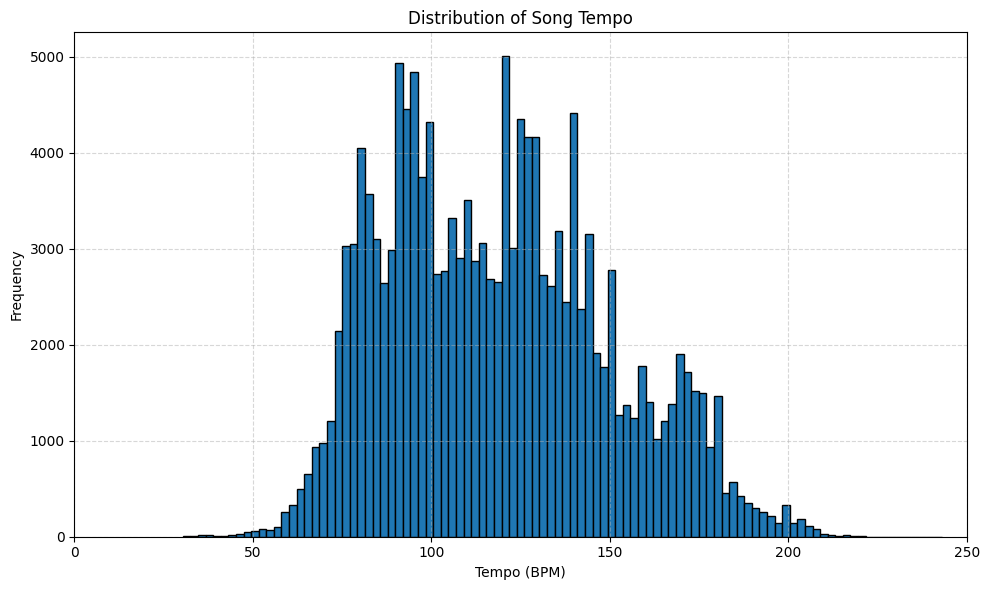

In [38]:
### IQR Analysis for Tempo ###

# Plot histogram of song tempo
plt.figure(figsize=(10, 6))
plt.hist(df['tempo'], bins=100, edgecolor='black')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Tempo')
plt.xlim(0, 250)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

We then explored the impact of energy on a song’s popularity by comparing songs in the top 10% of popularity to those outside of it. To visualize this, we used a violin plot to show the distribution of energy across both groups.

Both popular and non-popular songs span a wide range of energy values, but popular songs tend to have slightly higher energy on average.

Non-popular songs display a broader and more even spread, including a greater number of low-energy tracks.

This visualization suggests that higher energy levels may contribute to a song’s likelihood of becoming popular. This aligns with the idea that mainstream songs are often more energetic, helping them appeal to a wider audience.

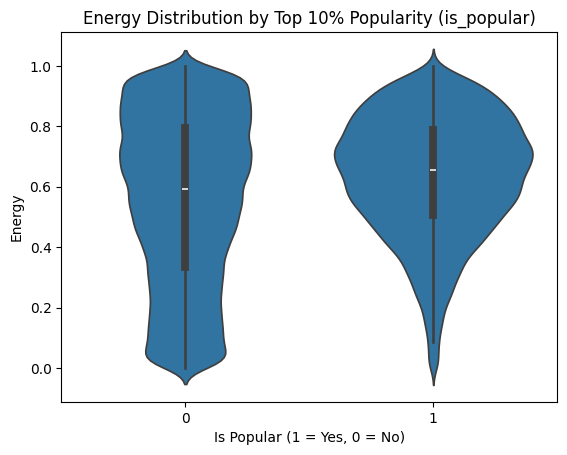

In [39]:
# Violin plot for is_popular vs energy
sns.violinplot(x='is_popular', y='energy', data=df)
plt.title('Energy Distribution by Top 10% Popularity (is_popular)')
plt.xlabel('Is Popular (1 = Yes, 0 = No)')
plt.ylabel('Energy')
plt.show()

We also calculated the Interquartile Range (IQR) for both popular and non-popular songs. The results confirmed that popular songs have a more consistent range of energy values, while non-popular songs display a broader and more varied energy distribution. This supports the idea that popularity may be linked to a more specific and energetic sound profile.

In [40]:
# Calculate IQR for energy based on is_popular
print("IQR (Popular):", df[df['is_popular'] == 1]['energy'].quantile(0.75) - df[df['is_popular'] == 1]['energy'].quantile(0.25))
print("IQR (Not Popular):", df[df['is_popular'] == 0]['energy'].quantile(0.75) - df[df['is_popular'] == 0]['energy'].quantile(0.25))

IQR (Popular): 0.281
IQR (Not Popular): 0.459


We then created a scatter plot with correlation coefficients to visualize the relationship between danceability and loudness in the dataset.

The Pearson correlation coefficient was calculated to be 0.47, indicating a moderately positive relationship between the two variables. This suggests that, in general, louder songs tend to be more danceable.

Most songs have loudness values between -30 dB and 0 dB.

Danceability scores are mostly concentrated between 0.4 and 0.8.

While a few outliers in loudness exist, the overall pattern remains consistent.

This scatter plot highlights a meaningful relationship between danceability and loudness, supporting their inclusion as useful features for analyzing and predicting song popularity.

Summary Statistics for Danceability:
count    150093.000000
mean          0.543978
std           0.190236
min           0.057000
25%           0.416000
50%           0.561000
75%           0.688000
max           0.987000
Name: danceability, dtype: float64

Summary Statistics for Loudness:
count    150093.000000
mean         -9.696042
std           6.341007
min         -52.457000
25%         -12.008000
50%          -7.686000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64


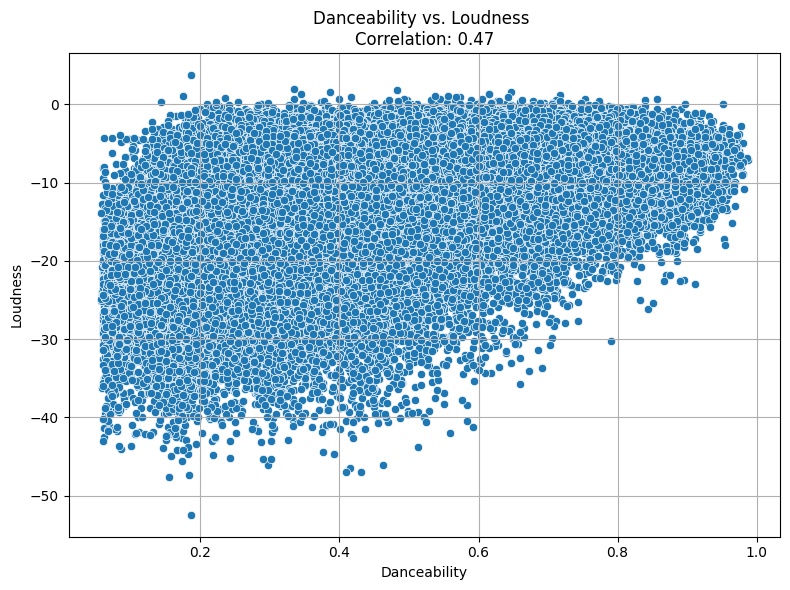

In [41]:
# Scatter plot for loudness vs. danceability
x = 'danceability'  # Defined variables
y = 'loudness'

corr_coeff = np.corrcoef(df[x], df[y])[0, 1] # Calculate the correlation coefficient

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

We conducted the same analysis on loudness and energy to examine how these two variables interact.

The resulting scatter plot shows a clear relationship between loudness and energy.

The Pearson correlation coefficient is 0.84, indicating a very strong positive correlation. This means that as loudness increases, energy levels also tend to increase. This pattern holds for the majority of songs in the dataset, with only a few outliers. This relationship is intuitive, as louder songs often feel more energetic and intense.

There is a sharp upward trend in energy as loudness rises from -30 dB to 0 dB.

At lower loudness levels, the distribution of energy is more spread out, while at higher loudness levels, it becomes more concentrated.

This strong correlation suggests that loudness is a highly predictive feature of energy in this dataset.

Summary Statistics for Loudness:
count    150093.000000
mean         -9.696042
std           6.341007
min         -52.457000
25%         -12.008000
50%          -7.686000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64

Summary Statistics for Energy:
count    150093.000000
mean          0.565372
std           0.274110
min           0.000020
25%           0.361000
50%           0.605000
75%           0.794000
max           0.999000
Name: energy, dtype: float64


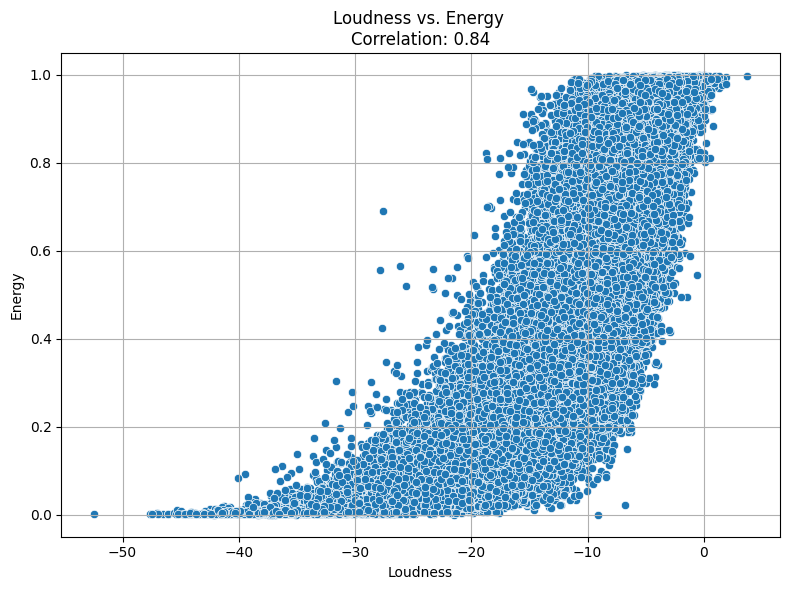

In [42]:
# Scatter plot for loudness vs energy
x = 'loudness' # Defined variables
y = 'energy'

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(df[x], df[y])[0, 1]

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot of loudness vs energy
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Our final visualization is a correlation matrix, presented as a heatmap showing the correlation coefficients between all numerical features in the dataset.

A strong positive correlation between energy and loudness stands out, confirming the relationship we observed in the "Loudness vs. Energy" scatter plot.

Danceability and valence also show a moderate positive correlation, suggesting that happier songs tend to be more danceable.

Acousticness and energy have a strong negative correlation, indicating that acoustic songs are typically quieter and less energetic—an intuitive relationship.

This correlation matrix provides valuable insight into the relationships between features. It helps identify potential redundancy among variables and highlights which features are most likely to contribute meaningful predictive value in our modeling process.


Correlation between loudness and energy: 0.84


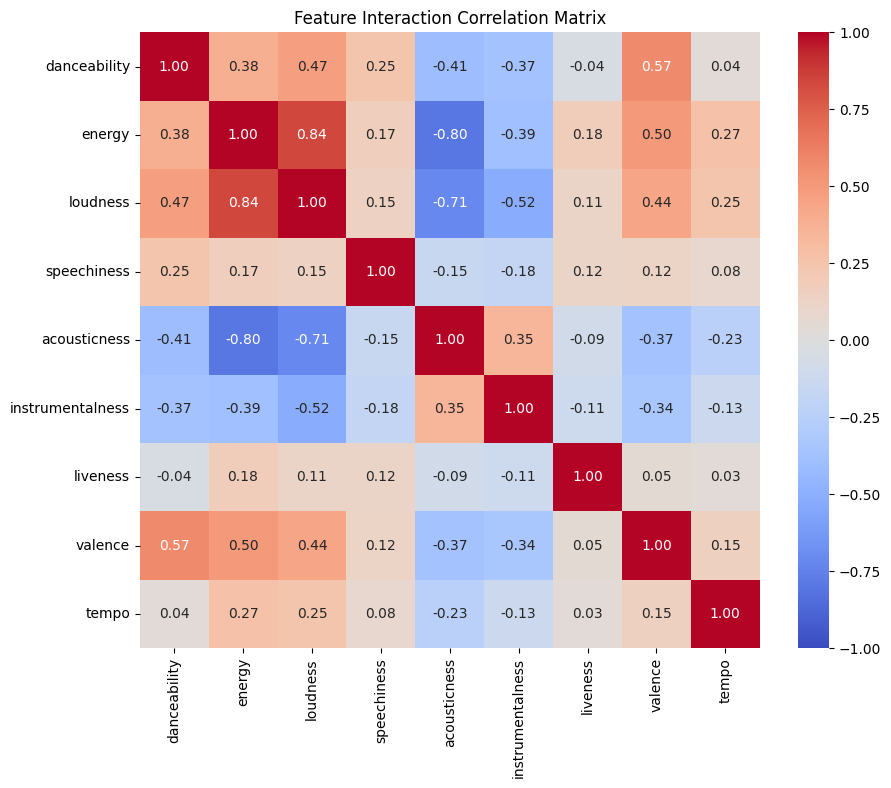

In [43]:
# Print the correlation coefficient
print(f"\nCorrelation between {x} and {y}: {corr_coeff:.2f}")

# Calculate pairwise correlation of features
corr_matrix = df[['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Interaction Correlation Matrix')
plt.show()

After EDA and cleaning, the final dataset contained 150,093 songs. 

In [44]:
# Data point check
print(f"After EDA and cleaning, the final dataset contains {df.shape[0]:,} songs.")

# Column check after EDA
print(f"\nColumns after EDA: {df.columns.tolist()}")

After EDA and cleaning, the final dataset contains 150,093 songs.

Columns after EDA: ['genre', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'duration_sec', 'is_popular']


### **Feature Engineering**

We applied several transformations to prepare the dataset for model training:

Converted the mode column from string values to binary to make it suitable for modeling.

One-hot encoded the genre and key columns to preserve their categorical meaning without introducing any ordinal relationship.

Created a new feature called vocalness, which captures the vocal intensity of a song by transforming the instrumentalness column.

Binned the tempo feature into three categories—slow, medium, and fast—and applied one-hot encoding to create a new column called tempo_category.

These transformations helped standardize the dataset, enhance feature interpretability, and ensure compatibility with the modeling algorithms.

In [45]:
### 3) Feature Engineering ###

# Convert mode from string to binary: Major = 1, Minor = 0
df['mode'] = df['mode'].map({'Minor': 0, 'Major': 1})

# One-hot encode genre variables
df = pd.get_dummies(df, columns=['genre', 'key'])

# One-hot encode time_signature variables
df = pd.get_dummies(df, columns=['time_signature'], prefix='ts')

# Create a new feature for vocalness as the inverse of instrumentalness (more vocals = less instrumental)
df['vocalness'] = 1 - df['instrumentalness']

# Bin tempo into categories: slow, medium, fast
df['tempo_category'] = pd.cut(
    df['tempo'],
    bins=[0, 90, 120, float('inf')],
    labels=['slow', 'medium', 'fast']
)

# One-hot encode tempo_category
df = pd.get_dummies(df, columns=['tempo_category'])

We also generated a correlation matrix that included our target variable, is_popular.

Loudness and energy remain highly correlated, consistent with earlier findings.

Vocalness shows a moderate positive correlation with the target variable, suggesting that more vocal-heavy songs may have a higher chance of being popular.

This feature engineering step helps improve model performance by enhancing interpretability, reducing noise, and ensuring that the features contribute meaningful information to the prediction task.

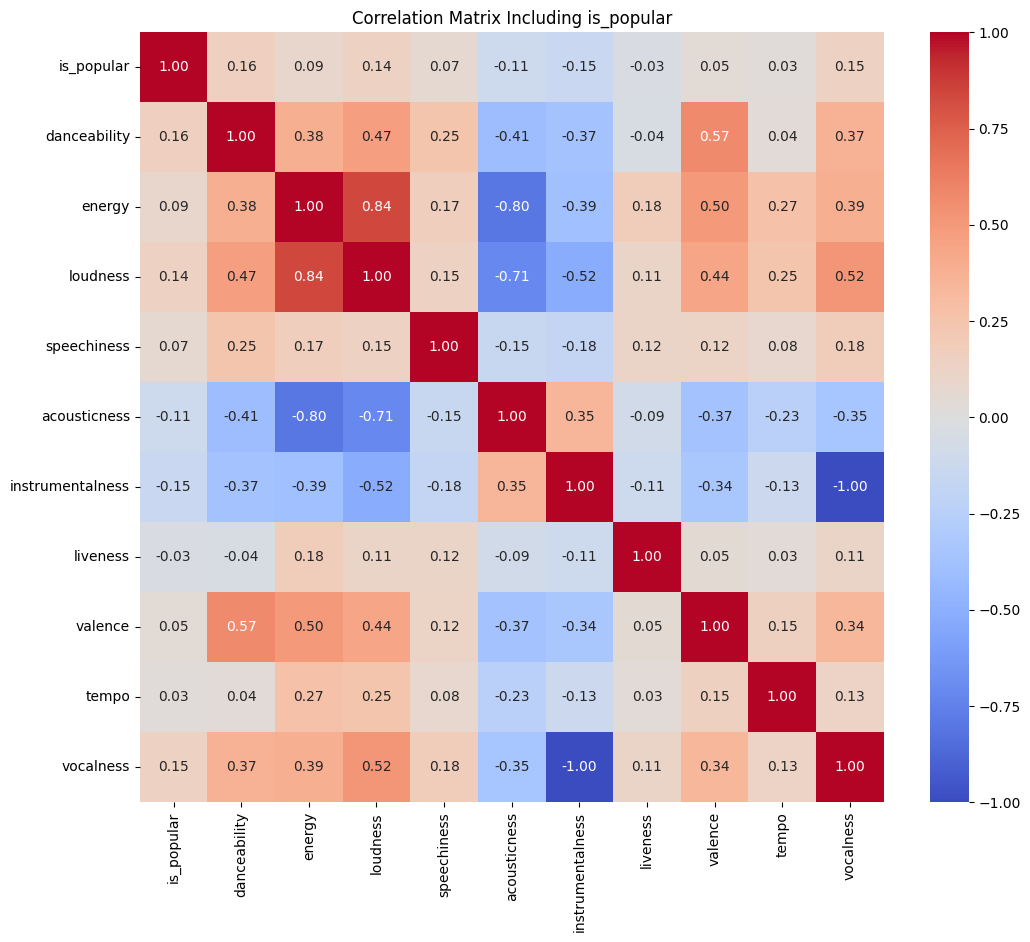

In [46]:
# Calculate correlation matrix including the target variable
corr_matrix = df[['is_popular', 'danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                  'vocalness']].corr()
                  
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including is_popular')
plt.show()

Lastly, we dropped columns that were no longer needed after transformation:

Instrumentalness, which was replaced by the newly created vocalness feature

Tempo, which was replaced by the bucketized tempo_category feature

Removing these columns helped simplify the dataset and avoid redundancy, ensuring that only relevant and transformed features were used in the modeling process.

In [47]:
# Drop the original instrumentalness column
df.drop(columns=['instrumentalness'], inplace=True)

# Drop the original tempo column to avoid redundancy
df.drop(columns=['tempo'], inplace=True)

Before proceeding with splitting and modeling, we performed final data quality checks to ensure the dataset was clean and ready.

We confirmed that there were no missing values or duplicate entries across any columns.

After completing all feature engineering steps, the dataset contains 150,093 songs and is well-structured for building predictive models.

In [48]:
# Data checkpoint after feature engineering
print("\nChecking for missing values in the dataset after feature engineering...") # Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values by column:")
print(missing_values) 
print("\nChecking for duplicate rows in the dataset...")
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f"Found {duplicates} duplicate rows.")
else:
    print("No duplicate rows found.")

print(f"\nAfter feature engineering, the dataset contains {df.shape[0]:,} songs.")

# Column check after feature engineering
print(f"\nColumns after feature engineering: {df.columns.tolist()}")


Checking for missing values in the dataset after feature engineering...
Missing values by column:
acousticness             0
danceability             0
energy                   0
liveness                 0
loudness                 0
mode                     0
speechiness              0
valence                  0
duration_sec             0
is_popular               0
genre_A Capella          0
genre_Alternative        0
genre_Anime              0
genre_Blues              0
genre_Classical          0
genre_Country            0
genre_Dance              0
genre_Electronic         0
genre_Folk               0
genre_Hip-Hop_Rap        0
genre_Indie              0
genre_Jazz               0
genre_Movie              0
genre_Opera              0
genre_Pop                0
genre_R&B                0
genre_Reggae             0
genre_Reggaeton          0
genre_Rock               0
genre_Ska                0
genre_Soul               0
genre_Soundtrack         0
genre_World              0
key_A     

### **Train/Validation/Test Split**

To prepare the dataset for modeling, we split the data into three parts:

Training set

Validation set

Test set

First, we split the dataset into a combined train/validation set (80%) and a test set (20%), using stratification on the is_popular column to preserve class balance.

Next, we further split the train/validation set into a training set (75%) and a validation set (25%), again using stratification to maintain consistency in class distribution.

We defined our feature columns by selecting all numerical columns except is_popular, which serves as our target variable. To ensure structural consistency across all data splits, we aligned the columns using the reindex() method.

This setup enables effective hyperparameter tuning on the validation set and unbiased performance evaluation on the test set.

After splitting, we successfully have a 60/20/20 split. This gives us a solid foundation for training and tuning.

In [49]:
### 4) Training/Testing Dataset Using Train/Validation/Test Splits ###

# First split: 80% train_val, 20% test
train_val_df, test_df = tts(
    df, test_size=0.2, stratify=df['is_popular'], random_state=42
)

# Second split: 75% train, 25% val from train_val → ends up as 60/20/20
train_df, val_df = tts(
    train_val_df, test_size=0.25, stratify=train_val_df['is_popular'], random_state=42
)

# Define feature columns after splitting from the original df
feature_cols = df.columns[df.columns != 'is_popular']

# Use reindex to align columns for each split
X_train = train_df.reindex(columns=feature_cols, fill_value=0)
y_train = train_df['is_popular']

X_val = val_df.reindex(columns=feature_cols, fill_value=0)
y_val = val_df['is_popular']

X_test = test_df.reindex(columns=feature_cols, fill_value=0)
y_test = test_df['is_popular']

# Output clean summary
print("\nTrain size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)
print("Training class distribution:", y_train.value_counts().to_dict())

# Column check after splitting
print(f"\nColumns after splitting: {X_train.columns.tolist()}")


Train size: (90055, 52)
Validation size: (30019, 52)
Test size: (30019, 52)
Training class distribution: {0: 80278, 1: 9777}

Columns after splitting: ['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'mode', 'speechiness', 'valence', 'duration_sec', 'genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues', 'genre_Classical', 'genre_Country', 'genre_Dance', 'genre_Electronic', 'genre_Folk', 'genre_Hip-Hop_Rap', 'genre_Indie', 'genre_Jazz', 'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska', 'genre_Soul', 'genre_Soundtrack', 'genre_World', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'ts_1', 'ts_3', 'ts_4', 'ts_5', 'vocalness', 'tempo_category_slow', 'tempo_category_medium', 'tempo_category_fast']


### **Rescaling the Data**

Next, we applied rescaling to the data. Rescaling is an important step in machine learning because features with widely different ranges can negatively affect the performance of certain models by introducing bias or instability.

In our case, we only applied scaling to the dataset used for the Logistic Regression model, as it is sensitive to feature magnitudes. Scaling was not applied to the dataset used for the Random Forest model, since tree-based models are generally unaffected by the scale of input features.

In [50]:
### 5) Rescaling Training Data ###

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
X_train_scaled = scaler.transform(X_train)

# Transform the validation and test data using the same scaler (no fitting, just transforming)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the first few rows of the scaled data to ensure it looks correct
print("\nScaled Training Data (first few rows):")
print(X_train_scaled[:5])

# Create separate SMOTETomek objects for each model to avoid overwriting

# For Logistic Regression (scaled features)
sm_lr = SMOTETomek(random_state=42)
X_train_resampled_lr, y_train_resampled_lr = sm_lr.fit_resample(X_train_scaled, y_train)

# For Random Forest (unscaled features)
sm_rf = SMOTETomek(random_state=42)
X_train_resampled_rf, y_train_resampled_rf = sm_rf.fit_resample(X_train, y_train)



Scaled Training Data (first few rows):
[[-0.90730709  0.55096039  0.87373672 -0.50249998  0.53996168  0.73306081
  -0.59665318 -0.5050666  -0.31078191 -0.0276909  -0.25099251 -0.24712028
  -0.2358666  -0.21539913 -0.22624053 -0.23523638 -0.24209759 -0.23447308
  -0.24808007 -0.15074711 -0.22384395  4.4849625  -0.22009868 -0.12850645
  -0.19132255 -0.24447866 -0.24099049 -0.11960024 -0.23761897 -0.1707768
  -0.2351838  -0.21491889 -0.33416554 -0.26499657 -0.28417443 -0.3676884
  -0.32713968 -0.34209723 -0.18228174 -0.28517731  3.24556365 -0.2564958
  -0.3664419  -0.26256455 -0.10103508 -0.32902904  0.38271036 -0.14273164
   0.24125282 -0.50675786  1.4170568  -0.92897173]
 [-0.75149468  1.34596988 -0.61899124 -0.25717459  0.03767706  0.73306081
  -0.1056556   0.91186782  2.27450896 -0.0276909  -0.25099251 -0.24712028
  -0.2358666  -0.21539913 -0.22624053 -0.23523638 -0.24209759 -0.23447308
  -0.24808007 -0.15074711 -0.22384395 -0.2229673  -0.22009868 -0.12850645
  -0.19132255  4.0903364

Because the dataset is imbalanced, we used SMOTETomek to balance the training data. This technique combines SMOTE (Synthetic Minority Over-sampling Technique) and Tomek links to improve class balance and reduce noise near decision boundaries.

We created two separate SMOTETomek-resampled datasets:

One for Logistic Regression, using the scaled features (X_train_scaled).

One for Random Forest, using the unscaled features (X_train), since tree-based models are not sensitive to feature scaling.

While SMOTE generates synthetic samples for the minority class, Tomek links help clean the data by removing ambiguous majority class samples that are close to the decision boundary. This approach is especially useful when working with highly imbalanced datasets and ensures both models can train fairly without being biased toward the majority class.

In [51]:
print("\nBefore oversampling:", np.bincount(y_train))
print("After oversampling for Logistic Regression:", np.bincount(y_train_resampled_lr))
print("After oversampling for Random Forest:", np.bincount(y_train_resampled_rf))


Before oversampling: [80278  9777]
After oversampling for Logistic Regression: [79975 79975]
After oversampling for Random Forest: [80193 80193]


### **Training and Tuning Candidate Models**

Now that our data is cleaned, engineered, and balanced, we move into training and evaluating predictive models. Our objective was to maximize ROC AUC, a robust metric for binary classification.

We began with Logistic Regression as a strong, interpretable baseline model. To optimize its performance, we used GridSearchCV to tune hyperparameters across three different solver configurations:

liblinear

saga

lbfgs

Each model was trained on the rescaled training set using stratified k-fold cross-validation, ensuring balanced class representation in each fold. The evaluation metric used was ROC AUC, which measures the model’s ability to distinguish between classes—a key metric for our imbalanced classification task.

The most effective configuration used the lbfgs solver, achieving a ROC AUC score of 0.89782. While the saga solver produced a nearly identical score, lbfgs was preferred due to its simpler setup and faster convergence. This result indicates that the model is effectively separating the positive and negative classes across a range of classification thresholds.

In [52]:
### 6) Train/Tune Candidate Models ###

# Logistic Regression Model

# Define multiple Logistic Regression solver configurations
logreg_models = [
    {
        'model': LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    },
    {
        'model': LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced'),
        'params': [
            {
                'penalty': ['l1', 'l2'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            },
            {
                'penalty': ['elasticnet'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'l1_ratio': [0.0, 0.5, 1.0]  # Only for elasticnet
            }
        ]
    },
    {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
]

# Create a StratifiedKFold object for stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each configuration and run GridSearchCV
best_score = 0
best_model = None
best_params = None

for config in logreg_models:
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=stratified_kfold, # Stratified K-Fold cross-validation
        scoring='roc_auc', # Use AUC as scoring metric
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_resampled_lr, y_train_resampled_lr)
    
    print(f"\nSolver: {config['model'].solver}")
    print("Best Parameters for Logistic Regression:", grid.best_params_)
    print("Best cross-validation ROC AUC score for Logistic Regression:", grid.best_score_)
   
    
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_params = grid.best_params_

# Save the best performing model
best_logreg = best_model

print("\nBest Logistic Regression Model (Key Parameters):")
print(best_logreg)

Fitting 10 folds for each of 14 candidates, totalling 140 fits

Solver: liblinear
Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8978149955145407
Fitting 10 folds for each of 35 candidates, totalling 350 fits

Solver: saga
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8978215668084836
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Solver: lbfgs
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8978216840692606

Best Logistic Regression Model (Key Parameters):
LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)


After training the Logistic Regression model, we next explored a Random Forest Classifier.

To optimize its performance, we used RandomizedSearchCV to evaluate 18 randomly selected combinations of hyperparameters. The model was trained using stratified k-fold cross-validation and evaluated using ROC AUC to ensure consistent and fair assessment across class imbalances.

The best-performing configuration was found with the following hyperparameters:

n_estimators: 100

min_samples_split: 5

max_depth: 10

max_features: 'sqrt'

This setup achieved a cross-validation ROC AUC of approximately 0.89, making it the top-performing model in our comparisons. As a result, the Random Forest model was selected as our primary model for threshold tuning and final test evaluation.

In [53]:
#Random Forest Model
# Define the parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100,],       # Number of trees, removed 200 to try to prevent overfitting
    'max_depth': [5, 10, 20],         # Depth of trees, removed "None" to try to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Min samples to split
    'max_features': ['sqrt',] #'log2', None]  # Feature subset at each split, coded out None and log2 to save computational
}

# Initialize StratifiedKFold for cross-validation (10-fold)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV with Random Forest
random_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_rf,
    n_iter=18,                  # 25 random combinations
    cv=stratified_kfold,        # Stratified K-Fold cross-validation
    scoring='roc_auc',          # Use AUC as scoring metric
    n_jobs=-1,                  # Use all available CPU cores
    verbose=1,                  
    random_state=42            
)

# Fit the model on the training data (no scaling needed for Random Forest)
random_rf.fit(X_train_resampled_rf, y_train_resampled_rf)

# Output the best hyperparameters and best cross-validation score
print("\nBest parameters for Random Forest:", random_rf.best_params_)
print("\nBest cross-validation ROC AUC score for Random Forest:", random_rf.best_score_)

# Save the best model for future use
best_rf = random_rf.best_estimator_

print("\nBest Random Forest Model (Key Parameters):")
print(best_rf)

Fitting 10 folds for each of 18 candidates, totalling 180 fits

Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}

Best cross-validation ROC AUC score for Random Forest: 0.9721905126292721

Best Random Forest Model (Key Parameters):
RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)


In [54]:
### 6.5) Evaluating Tuned Models on the Validation Set ###

# Making predictions on the validation set

# Function to plot threshold metrics
def plot_threshold_metrics(thresholds, f1_scores, precisions, recalls, accuracies, title='Metric Performance vs. Classification Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
    plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Now, we evaluated both models—Logistic Regression and Random Forest—on the validation set before selecting the final model for testing. This step was important to assess how well each model generalized to unseen data.


We calculated key evaluation metrics, including:

F1 Score

Precision

Recall

Accuracy

An optimized threshold was also used for each model to maximize the F1 score, ensuring a balanced trade-off between precision and recall.

In [55]:
# Random Forest: Threshold Tuning

# Get predicted probabilities from the random forest model
y_val_probs_rf = best_rf.predict_proba(X_val)[:, 1]

# Store metrics for different thresholds
thresholds_rf = np.arange(0.1, 0.9, 0.05)
f1_scores_rf, precisions_rf, recalls_rf, accuracies_rf = [], [], [], []

for thresh in thresholds_rf:
    y_pred_thresh_rf = (y_val_probs_rf >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh_rf, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh_rf)

    precisions_rf.append(precision)
    recalls_rf.append(recall)
    f1_scores_rf.append(f1)
    accuracies_rf.append(acc)

# Find best threshold based on F1 score
best_idx_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]
print(f"\nBest threshold for Random Forest (by F1-score): {best_threshold_rf:.2f}")
print(f"Precision: {precisions_rf[best_idx_rf]:.2f}, Recall: {recalls_rf[best_idx_rf]:.2f}, F1: {f1_scores_rf[best_idx_rf]:.2f}, Accuracy: {accuracies_rf[best_idx_rf]:.2f}")

# Make final predictions using the best threshold
y_val_pred_rf_thresh = (y_val_probs_rf >= best_threshold_rf).astype(int)

# Final Random Forest Validation Performance
print("\nRandom Forest - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold_rf))
print(classification_report(y_val, y_val_pred_rf_thresh))


Best threshold for Random Forest (by F1-score): 0.55
Precision: 0.49, Recall: 0.63, F1: 0.55, Accuracy: 0.89

Random Forest - Validation Set Performance (Threshold = 0.55):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     26760
           1       0.49      0.63      0.55      3259

    accuracy                           0.89     30019
   macro avg       0.72      0.78      0.74     30019
weighted avg       0.90      0.89      0.89     30019



After training and tuning the Random Forest model, we evaluated its performance on the validation set by varying the classification threshold.

We iterated through multiple thresholds and calculated key evaluation metrics at each level.

The optimal threshold for the Random Forest model, based on the F1 Score, was found to be 0.55.

Overall, the model demonstrated strong performance in identifying truly popular songs, achieving a recall of 63%. This high recall suggests the model is effective at capturing potential hits, which could be particularly valuable if the goal is to prioritize discovery—even at the expense of a higher false positive rate.



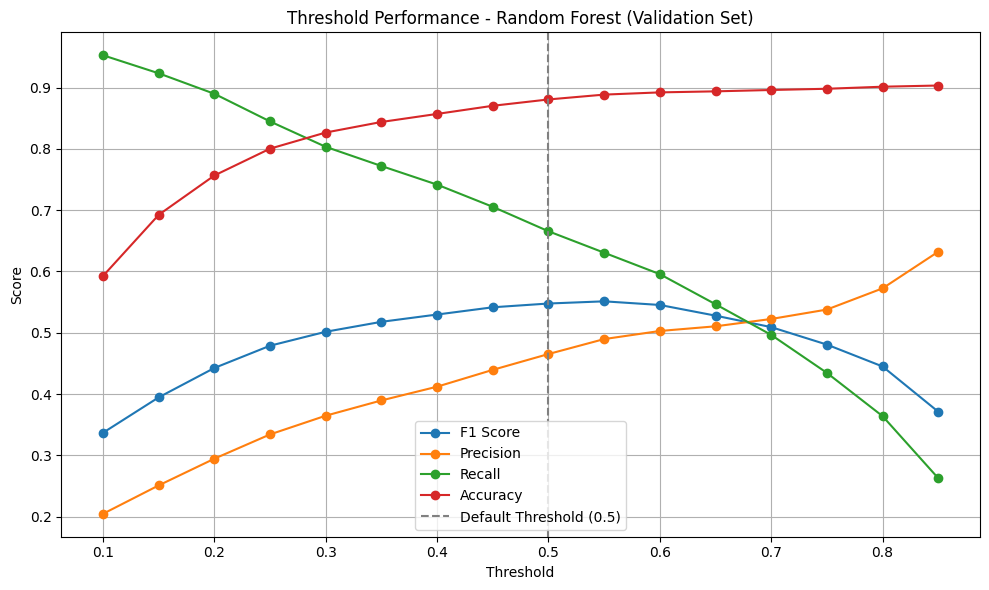

In [56]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds_rf,
    f1_scores_rf,
    precisions_rf,
    recalls_rf,
    accuracies_rf,
    title='Threshold Performance - Random Forest (Validation Set)'
)

This plot illustrated how varying the classification threshold impacted key performance metrics on the validation set for the Random Forest model.

As the threshold increased, the model became more conservative, predicting fewer songs as popular.

This shift resulted in higher precision but lower recall, as the model missed more truly popular songs.

Accuracy improved with higher thresholds since the majority class (non-popular songs) was predicted more frequently.

The F1 Score peaked at a threshold of 0.55, representing the optimal balance between precision and recall for detecting popular songs.

Using a custom threshold allowed us to better target the top 10% of popular songs while managing the trade-off between missed hits and false positives.

In [57]:
# Logistic Regression: Threshold Tuning

# Get predicted probabilities from logistic regression model
y_val_probs = best_logreg.predict_proba(X_val_scaled)[:, 1]

# Store metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores, precisions, recalls, accuracies = [], [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_val_probs >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(acc)

# Find best threshold based on F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest threshold (by F1-score): {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}, Accuracy: {accuracies[best_idx]:.2f}")

# Make final predictions using the best threshold
y_val_pred_lr = (y_val_probs >= best_threshold).astype(int)

# Final Logistic Regression Validation Performance
print("\nLogistic Regression - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold))
print(classification_report(y_val, y_val_pred_lr))


Best threshold (by F1-score): 0.75
Precision: 0.49, Recall: 0.65, F1: 0.56, Accuracy: 0.89

Logistic Regression - Validation Set Performance (Threshold = 0.75):
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     26760
           1       0.49      0.65      0.56      3259

    accuracy                           0.89     30019
   macro avg       0.72      0.78      0.75     30019
weighted avg       0.90      0.89      0.89     30019



Next, we evaluated the performance of the Logistic Regression model using the same key metrics as the Random Forest model: F1 Score, Precision, Recall, and Accuracy on the validation set.

The optimal threshold for the Logistic Regression model, based on the F1 Score, was found to be 0.56.

Compared to the Random Forest model, Logistic Regression achieved the same precision but demonstrated a higher recall, meaning it identified more true positives.

Additionally, the accuracy of the Logistic Regression model matched that of the Random Forest model, indicating similar overall predictive performance across both models.

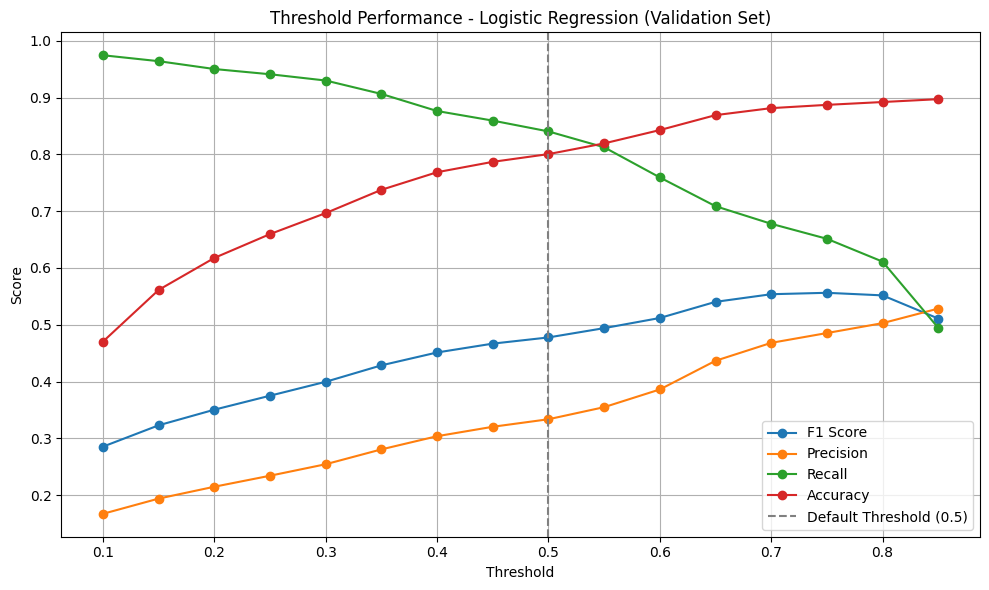

In [58]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds,
    f1_scores,
    precisions,
    recalls,
    accuracies,
    title='Threshold Performance - Logistic Regression (Validation Set)'
)

# Function to plot the confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Popular', 'Popular'],
                yticklabels=['Not Popular', 'Popular'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

Compared to the Random Forest threshold performance chart, the chart for Logistic Regression displayed many of the same patterns. The overall shape of the metric curves across different thresholds was very similar between the two models.

This chart demonstrated how varying the classification threshold affected the Logistic Regression model’s performance on the validation set:

As the threshold increased, precision increased while recall decreased—highlighting the trade-off between being more selective versus capturing more true positives.

The F1 Score peaked at a threshold of approximately 0.75, representing a balanced trade-off between precision and recall.

Accuracy also increased with higher thresholds, as the model predicted the majority class (non-popular songs) more frequently.

These trends reinforced the importance of threshold tuning to align model behavior with the specific goals of the task.

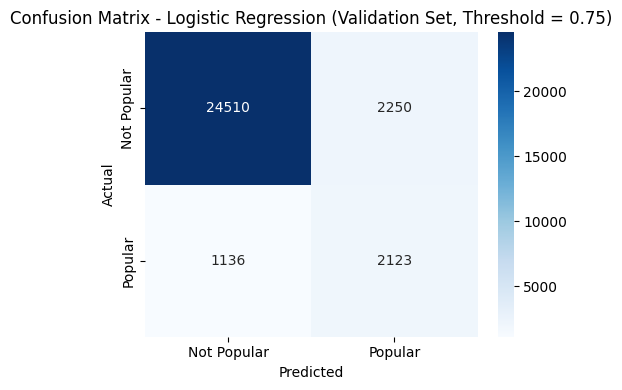

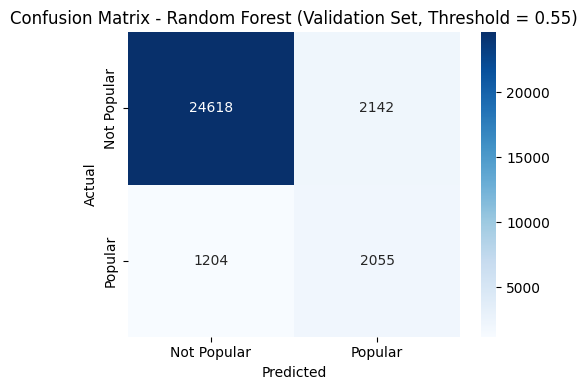

In [59]:
# Confusion matrices at optimized thresholds
plot_conf_matrix(
    y_val,
    y_val_pred_lr,
    f"Confusion Matrix - Logistic Regression (Validation Set, Threshold = {best_threshold:.2f})"
)

plot_conf_matrix(
    y_val,
    y_val_pred_rf_thresh,
    f"Confusion Matrix - Random Forest (Validation Set, Threshold = {best_threshold_rf:.2f})"
)


So far, we explored a range of classification thresholds to identify the best balance among key evaluation metrics—F1 Score, Precision, Recall, and Accuracy.

We also visualized how these performance metrics changed across thresholds and plotted confusion matrices for both models to examine their classification performance in more detail.

These insights provided a clearer understanding of each model’s strengths and trade-offs, helping guide the selection of the most effective model for final evaluation on the test set.

We ultimately chose the Random Forest model over Logistic Regression because, despite both models achieving similar accuracy and precision, Random Forest consistently delivered higher recall. Its ensemble nature also made it more robust to noise and outliers, which improved its generalizability to unseen data.

This final trade-off demonstrates that the Random Forest model effectively captures the underlying patterns of popularity while providing reliable performance, especially when the goal is to prioritize discovering potential hits.

### **Characterizing Model Performance on Test Set**

After fine-tuning and validating the Random Forest model, we assessed its performance on the test set using the optimized threshold determined during the validation phase.

This evaluation provided a realistic estimate of how the model would perform in a real-world or production setting.

In [60]:
### 7) Characterizing random forest model performance on testing set ###

# 1. Predict probabilities and apply threshold
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)

# 2. Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Confusion matrix + specificity
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)

# Print results
print(f"Random Forest - Test Set (Threshold = {best_threshold_rf:.2f}):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Sensitivity (Recall): {recall_rf:.4f}")
print(f"Specificity: {specificity_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest - Test Set (Threshold = 0.55):
Accuracy: 0.8873
Sensitivity (Recall): 0.6241
Specificity: 0.9194
Precision: 0.4853
F1 Score: 0.5460
AUC: 0.8857


Some final remarks on the Random Forest model's performance:

The model maintained a high recall of 62%, indicating it correctly identified most of the truly popular songs.

Its moderate precision reflected a relatively high number of false positives, which was expected given the emphasis on recall.

The high accuracy of 89% suggested strong overall predictive performance, although this value was somewhat inflated due to the class imbalance.

An AUC of 0.89 demonstrated the model’s ability to rank predictions effectively across all classification thresholds.

Overall, this trade-off showed that the model captured the characteristics of popularity well. These insights highlighted both the strengths and limitations of the Random Forest model and supported its use in tasks where identifying potential hits was a primary objective.

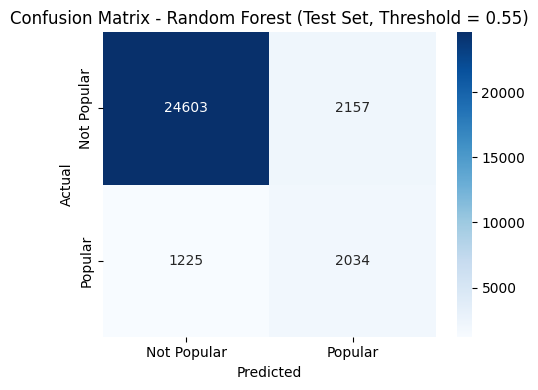

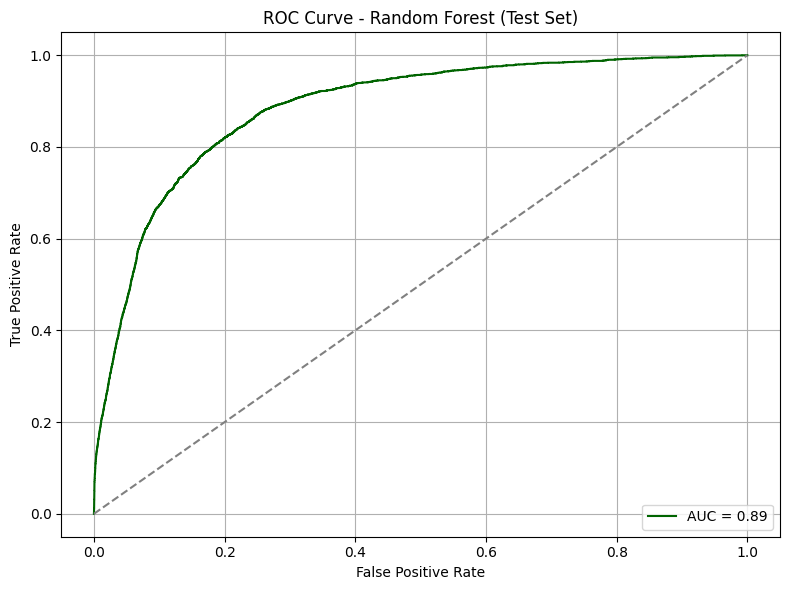

In [61]:
# Plot confusion matrix
plot_conf_matrix(
    y_test,
    y_pred_rf,
    f"Confusion Matrix - Random Forest (Test Set, Threshold = {best_threshold_rf:.2f})"
)

# ROC Curve for Random Forest
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkgreen')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot it
plot_roc_curve(
    y_test,
    y_prob_rf,
    title=f'ROC Curve - Random Forest (Test Set)'
)


The confusion matrix highlighted the model's tendency to classify songs as popular, which resulted in a lower number of false negatives but a higher number of false positives.

The ROC curve for the Random Forest model on the test set provided a visual summary of its classification performance. An AUC of 0.89 indicated strong overall effectiveness, suggesting that the model was highly capable of distinguishing popular songs from non-popular ones.

While the model showed significant potential—particularly in terms of recall—the trade-offs in precision should be carefully considered, depending on the specific goals of the application.

### **Summary**

The Random Forest model demonstrated strong generalization on the test set, effectively managing class imbalance while maintaining solid recall and precision. With an AUC of 0.89, it showed excellent ability to rank and distinguish between popular and non-popular songs.

This makes the model well-suited for real-world applications such as:

Identifying potential breakout songs

Recommending high-potential tracks

Prioritizing songs for marketing or further analysis

All evaluations were conducted on unseen test data, ensuring that the performance results are reliable and unbiased.